<a href="https://colab.research.google.com/github/JALVARADORUIZ/Magister_BigData_UB/blob/main/M7_AI4_JoseAlvaradoRuiz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*PADAWAN*: 


##JOSE ARMANDO ALVARADO RUIZ


**Entrega: GENERACIÓN DE TEXTO**


# **Descripción de la tarea**

###Contexto

En esta actividad utilizaremos una Red Neuronal Recurrente para generar texto. Esta es una funcionalidad básica para chatbots, asistentes de voz, etc.

Se sugiere utilizar el fichero The-Collected-Works-of-HP-Lovecraft que recopila obras del escritor H.P. Lovecraft. Está formado por 700.000 palabras, de las cuales 36.000 son únicas.

Alternativamente, puedes utilizar cualquier otro corpus que consideres.

Para realizar la actividad, te pedimos lo siguiente: 

- Carga del dataset.
- Preprocesado: utilizar la función “preprocess_corpus_if_necessary” del Colab proporcionado.
- Generar una Red Neuronal Recurrente para generar texto según el estilo del dataset: 
  - El primer nivel será de embeddings únicamente para reducir la dimensionalidad.
  - A continuación se añadirá una capa LSTM sencilla.
  - A la salida de la capa LSTM se insertará una capa lineal.
  - Esta capa lineal tendrá tantas salidas como palabras haya en el vocabulario.
- Entrenar el modelo: 
  - Se generará un dataset compuesto por frases, y cada frase se obtiene escogiendo aleatoriamente del corpus una secuencia de palabras de longitud determinada y utilizando la palabra siguiente como etiqueta.
- Evaluación del modelo: 
  - Grafica las curvas de loss y accuracy. 
  - Comenta los resultados. 
  - Genera textos y comprueba si son coherentes y se parecen al estilo del corpus. Utiliza la función “generate_texts” del Colab proporcionado. 

Consideraciones:
- Framework a utilizar: Tensorflow.
- Recuerda activar la GPU en el menú “Entorno de ejecución” => “Cambiar tipo de entorno de ejecución”.
- Conviene revisar que las dimensiones de la Red son correctas antes de comenzar a entrenar.

# Generación de texto con una red LSTM
En esta actividad vamos a utilizar una red recurrente LSTM para generar texto.

El corpus que sirve de referencia para generar los textos se compone de obras de H.P. Lovecraft, aunque se puede utilizar cualquier otro.

El interés de esta actividad es utilizar las redes **LSTM para algo distinto de una clasificación**, aunque, como se puede observar, la calidad de los textos generados es inferior a la que se consigue con otros modelos más actuales, como los transformer.

**Debes completar el código en las secciones indicadas con # COMPLETAR CODIGO**

## Instalación e importación de paquetes

In [1]:
!pip install progressbar2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import urllib
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import html
import requests

import nltk
from nltk import word_tokenize
nltk.download('punkt')
import pickle
import random
import progressbar
from tensorflow.keras import models, layers
from tensorflow.keras.utils import to_categorical

try:
    from nltk.tokenize.moses import MosesDetokenizer
    detokenizer = MosesDetokenizer()
    use_moses_detokenizer = True
except:
    use_moses_detokenizer = False

print(f"use_moses_detokenizer={use_moses_detokenizer}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


use_moses_detokenizer=False


## Definición de parámetros del corpus y su preprocesado

In [3]:
corpus_url = "https://www.gutenberg.org/cache/epub/11/pg11.txt"
corpus_path = "pg11.txt"
preprocessed_corpus_path = "alicia_preprocessed.p"
most_common_words_number = 10000


## Tranformación entre palabras e índices
Se definen dos funciones:
* **encode_sequence**: codifica una secuencia de palabras en una secuencia de índices
* **decode_indices**: decodifica una secuencia de índices en la secuencia de palabras correspondiente

In [4]:
def encode_sequence(sequence, vocabulary):

    return [vocabulary.index(element) for element in sequence if element in vocabulary]


def decode_indices(indices, vocabulary):

    decoded_tokens = [vocabulary[index] for index in indices]
    if use_moses_detokenizer  == True:
        return detokenizer.detokenize(decoded_tokens, return_str=True)
    else:
        return " ".join(decoded_tokens)

## Descarga del corpus
Solo se descarga si no se encuentra en local (Colab o disco)

In [5]:
def download_corpus_if_necessary():

  if not os.path.exists(corpus_path):
       print("Descargamos el corpus...")

       # Descargamos el contenido
       corpus_string = requests.get(corpus_url).content.decode('utf-8')

       # Eliminamos etiquetas HTML
       corpus_string = corpus_string.replace("<pre>", "")
       corpus_string = corpus_string.replace("</pre>", "")

       # Grabamos en fichero
       corpus_file = open(corpus_path, "w")
       corpus_file.write(corpus_string)
       corpus_file.close()

       print("El corpus se ha grabado en", corpus_path)
  else:
       print("El corpus ya estaba grabado")

download_corpus_if_necessary()

Descargamos el corpus...
El corpus se ha grabado en pg11.txt


## Preprocesado del corpus
Solo se preprocesa si no se ha hecho antes.

In [6]:
def preprocess_corpus_if_necessary():

    if not os.path.exists(preprocessed_corpus_path):
        print("Preprocesamos el corpus...")

        corpus_file = open(corpus_path, "r")
        corpus_string = corpus_file.read()

        # Generación del vocabulario
        print("Extraemos las palabras (tokens)...")
        corpus_tokens = word_tokenize(corpus_string)
        print("Número de tokens:", len(corpus_tokens))
        print("Generamos el vocabulario...")
        word_counter = Counter()
        word_counter.update(corpus_tokens)
        print("Longitud del vocabulario antes del corte:", len(word_counter))
        vocabulary = [key for key, value in word_counter.most_common(most_common_words_number)]
        print("Longitud del vocabulario después del corte:", len(vocabulary))

        # Conversión a índices
        print("Codificamos a índices...")
        indices = encode_sequence(corpus_tokens, vocabulary)
        print("Número de índices:", len(indices))

        # Saving.
        print("Grabamos fichero de preprocesado del corpus...")
        pickle.dump((indices, vocabulary), open(preprocessed_corpus_path, "wb"))
    else:
        print("El corpus ya estaba preprocesado")

preprocess_corpus_if_necessary()

Preprocesamos el corpus...
Extraemos las palabras (tokens)...
Número de tokens: 36924
Generamos el vocabulario...
Longitud del vocabulario antes del corte: 3782
Longitud del vocabulario después del corte: 3782
Codificamos a índices...
Número de índices: 36924
Grabamos fichero de preprocesado del corpus...


## Generación del dataset
Enfocamos la generación del dataset como un **aprendizaje auto-supervisado (self-supervised learning)**:
* para generar secuencias de entrada, seleccionamos de forma aleatoria una secuencia de índices (correspondientes a palabras) del corpus
* para asignar una etiqueta, escogemos el índice de la palabra siguiente a la secuencia de entrada

In [7]:
# Parámetros de generación del dataset
dataset_size = 50000
sequence_length = 30 # longitud de los textos del dataset de entrenamiento

def get_dataset(indices):

    data_input = []
    data_output = []
    current_size = 0
    bar = progressbar.ProgressBar(max_value=dataset_size)
    while current_size < dataset_size:

        # seleccionamos de forma aleatoria una secuencia de índices (correspondientes a palabras)
        random_index = random.randint(0, len(indices) - (sequence_length + 1))
        input_sequence = indices[random_index:random_index + sequence_length]
        # la etiqueta de la secuencia aleatoria es el índice de la siguiente palabra
        output_label = indices[random_index + sequence_length]

        data_input.append(input_sequence)
        data_output.append(output_label)

        current_size += 1
        bar.update(current_size)
    bar.finish()

    # Transformamos las listas a numpy arrays
    data_input = np.array(data_input)
    data_output = np.array(data_output)
    return (data_input, data_output)


## Definición de la red LSTM y entrenamiento
Solo se define y entrena si no se ha hecho antes, o si se fuerza con el parámetro train_anyway.

Por último, se graba el modelo.

https://ai-guru.de/artificial-intelligence/deep-learning-and-weird-fiction/

 77% (38608 of 50000) |#############     | Elapsed Time: 0:00:00 ETA:   0:00:00


Generamos el dataset...


100% (50000 of 50000) |##################| Elapsed Time: 0:00:00 Time:  0:00:00


Creamos el modelo...
3782 30
Creating model...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 30, 1000)          3782000   
                                                                 
 lstm_2 (LSTM)               (None, 1000)              8004000   
                                                                 
 dense_2 (Dense)             (None, 3782)              3785782   
                                                                 
 activation (Activation)     (None, 3782)              0         
                                                                 
Total params: 15,571,782
Trainable params: 15,571,782
Non-trainable params: 0
_________________________________________________________________
Entrenamos el modelo...
Epoch 1/10
391/391 [==============================] - 27s 65ms/step - loss: 5.7377 - categorical_accura

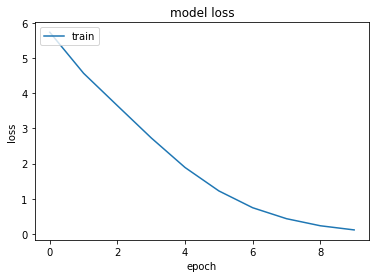

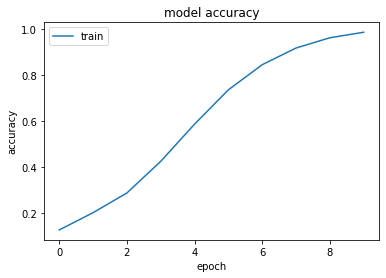

In [10]:
# Parámetros del modelo y entrenamiento
train_anyway = True # fuerza el entrenamiento, aunque se haya realizado antes
epochs = 10 # número de interaciones a entrenar
batch_size = 128 # tamaño de lote
hidden_size = 1000 # número de nodos en la red LSTM
model_path = "alicia_model.h5"

def train_neural_network():

    if not os.path.exists(model_path) or train_anyway == True:

        # Carga de las palabras del corpus y sus índices
        indices, vocabulary = pickle.load(open(preprocessed_corpus_path, "rb"))

        # Generación del dataset
        print("\nGeneramos el dataset...")
        data_input, data_output = get_dataset(indices)
        data_output = to_categorical(data_output, num_classes=len(vocabulary))

        # Creación del modelo
        print("Creamos el modelo...")
         
        # COMPLETAR CODIGO (debes seguir las indicaciones de la actividad para generar la red LSTM) 
        input_dim = len(vocabulary)
        seq_length = data_input.shape[1]
        print(input_dim, seq_length)

        # Creating the model.
        print("Creating model...")
        model = models.Sequential()
        model.add(layers.Embedding(input_dim, hidden_size, input_length=sequence_length))
        model.add(layers.LSTM(hidden_size))
        model.add(layers.Dense(input_dim))
        model.add(layers.Activation('softmax'))
        model.summary()

        # Definimos el resto del modelo: optimizador, función de pérdidas y métrica
        # COMPLETAR CODIGO
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

        # Entrenamiento del modelo
        print("Entrenamos el modelo...")
        history = model.fit(data_input, data_output, batch_size=batch_size, epochs=epochs)
        
        loss, accuracy = model.evaluate(data_input, data_output, verbose=0)
        print('Accuracy: %f' % (accuracy*100))
        # Grabación del modelo
        print("...y grabamos el modelo")
        model.save(model_path)

        plot_history(history)
        

def plot_history(history):

    print(history.history.keys())

    # Gráfica de función de pérdida
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig("history_loss.png")
    # plt.clf()
    plt.show()
    plt.close()
    
    # Gráfica de accuracy.
    plt.plot(history.history['categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig("history_accuracy.png")
    # plt.clf()

    plt.show()
    plt.close()
        
train_neural_network()

Podemos ver que el modelo presenta un alto clasification_accuracy que comienza a rondar el 99% en el epoch 10, y viendo la gráfica nos muestra una curva que se comienza a aplanar, además de mostrar que loss tiende a 0.10 en la misma cantidad de epoch.

## Generación de texto

La generación de texto se basa en la función **get_index_from_prediction**, que obtiene un índice a partir de una predicción y un parámetro de temperatura 

In [11]:
# Parámetros de generación de texto
generated_sequence_length = 50 # longitud de los textos generados
n_generated_texts = 15 # número de textos a generar

def generate_texts(n_generated_texts=10):

    print(f"Generamos {n_generated_texts} textos...")

    # carga del corpus
    indices, vocabulary = pickle.load(open(preprocessed_corpus_path, "rb"))

    # carga del modelo previamente grabado
    model = models.load_model(model_path)

    # Generamos tantos textos como indique el parámetro n_generated_texts
    for _ in range(n_generated_texts):

        # Escogemos un parámetro aleatorio "temperature" para la predicción
        temperature = random.uniform(0.0, 1.0)
        print("Temperatura:", temperature)

        # Obtenemos una muestra aleatoria a modo de secuencia semilla a partir de la cual se generarán textos
        random_index = random.randint(0, len(indices) - (generated_sequence_length))
        input_sequence = indices[random_index:random_index + sequence_length]

        # Generamos la secuenca de salida repitiendo la predicción
        generated_sequence = []
        while len(generated_sequence) < generated_sequence_length:
            prediction = model.predict(np.expand_dims(input_sequence, axis=0))
            predicted_index = get_index_from_prediction(prediction[0], temperature)
            generated_sequence.append(predicted_index)
            input_sequence = input_sequence[1:]
            input_sequence.append(predicted_index)

        # Convertimos la secuencia de índices generada en una frase
        text = decode_indices(generated_sequence, vocabulary)
        print(text)
        print("")

        
def get_index_from_prediction(prediction, temperature=0.0):

    # Temperatura cero - usamos argmax.
    if temperature == 0.0:
        return np.argmax(prediction)

    # Temperatura distinta de cero - aplicamos cierta aleatoriedad
    else:
        prediction = np.asarray(prediction).astype('float64')
        prediction = np.log(prediction) / temperature
        exp_prediction= np.exp(prediction)
        prediction = exp_prediction / np.sum(exp_prediction)
        probabilities = np.random.multinomial(1, prediction, 1)
        return np.argmax(probabilities)


generate_texts(n_generated_texts)

Generamos 15 textos...
Temperatura: 0.850907088954256
. ' -- and fetch it voice again , I must think come much quite day . ' For some more their faster , ' I could n't have changed out it . ' ( Dinah , as well as she went , to see that 's about all the

Temperatura: 0.05625643459373442
, as nearly as she had got to her . 'Oh , it must be a little use in the middle of this license , and the sneeze was a notice trademark , and the medium , it was too much , that it just much down and but it

Temperatura: 0.32969692837263975
executed for having missed their turns , but she did not like the look of the house , and thought she had forgotten that it was only a game of play with a cart-horse , feeling a large pigeon had flown into its arms , half the legs of the

Temperatura: 0.42370830675412463
of the March Hare , and the Queen was looking about for some time with it : 'No , just ' I could n't afford ! ' said Alice , 'and then she had grown so much and bread-and-butter . ' 'But I should n't 

Vemos que los textos generados son legibles pero no son lo más preciso aunque se tiene un alto clasification accuracy, esto debido a que se utiliza una Red Neronal LSTM con una arquitectura secuencial simple. Comienza con una capa de incrustación, seguida de una capa LSTM y termina con una capa densa (lineal). 

En esencia, aquí tenemos un clasificador múltiple. Esta es la razón por la que tiene sentido utilizar categorical_crossentropy como función de pérdida. El optimizador Adam siempre es una buena opción. Y el categorical_accuracy como métrica es una mera consecuencia.